<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_29_PRAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 29회 ADP 복원

In [1]:
# 1. 한글 폰트 설치 (나눔고딕 예시)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 기계학습 (60점)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler , LabelEncoder , MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, r2_score

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15094266/fileData.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv
- 데이터 설명 : 대구도시공사_빅데이터_영구임대아파트 입주자 퇴거여부 데이터, 고유번호를 가진 계약자와 특정 아파트에 대해 매년 퇴거여부를 기록한 데이터

In [3]:
#encoding = ['utf-8','cp949','utf-8-sig','euc-kr','latin']
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv',encoding= 'cp949')
df.head(3)

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,...,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2008,47100,3646000,46,33,남,미혼,3,미퇴거
1,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2009,56500,4375000,46,34,남,미혼,3,미퇴거
2,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2010,56500,4375000,46,35,남,미혼,3,미퇴거


#### 1-1  계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [4]:
df_sorted = df.sort_values(['계약자고유번호','거주연도'], ascending= [True, False])\
            .drop_duplicates('계약자고유번호', keep = 'first').reset_index(drop = True)

In [5]:
# 문제이해 - 가장 최신의 거주연도만 남아야하기 때문에, 정렬을 한다.
# 즉, 가장 최근의 연도에 표시를 해주거나, 정렬로 각 계약자고유번호마다의 최신 거주 연도를 추출
# 1. 거주연도 내림차순 정렬
df_sorted = df.sort_values(['계약자고유번호','거주연도'], ascending= [True, False])

# 2. 계약자 고유번호별 최신 데이터
df_dup = df_sorted.drop_duplicates('계약자고유번호', keep = 'first').reset_index(drop = True)
df_dup.shape

(10348, 23)

In [6]:
# 이 코드는 쌍이 중복되는 컬럼 값만 제거되는 것이지 계약자 별로 거주 연도의 최대값을 남기는 것은 아니다.
df.drop_duplicates(subset = ['계약자고유번호','거주연도'] , keep= 'first').reset_index(drop = True).shape

(86810, 23)

In [7]:
# 방법 2)
# First : 처음 나타나는 중복값 / Last : 마지막에 나타나는 중복값
df1 = df.copy()
# 1) 각 계약자고유번호별 최신 날짜 Dictionary로 만들기
year_max = df.groupby(['계약자고유번호'])['거주연도'].max().to_dict()

# 2) 계약자고유번호에 Mapping후 새로운 컬럼 생성
df1['max_year'] = df1['계약자고유번호'].map(year_max)

# 3) 최신 같은 연도 필터링
df1 = df1[df1['거주연도'] == df1['max_year']]

# 4) 계약자 중복행제거
d_df = df1.sort_values(['계약자고유번호','거주연도']).drop_duplicates(['계약자고유번호'], keep = 'first').reset_index(drop = True)

#### 1-2 결측치 처리

In [8]:
df_sorted.isna().sum().to_frame().T

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,...,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,0,508,0,0,0,0,1225,0,0,0,...,61142,0,0,0,0,0,0,0,0,0


In [9]:
# 1. 계약 구분 - 유효/해지
df_sorted['계약구분'] = df_sorted.apply(lambda x : '유효' if x['퇴거여부'] == '미퇴거' else '해지', axis = 1)

In [10]:
# 2. 아파트 평점 - 각 아파트의 평점이 같기 때문에 고유값을 매핑
score = df_sorted.groupby('아파트 이름')['아파트 평점'].unique().reset_index()
score['아파트 평점'] = score['아파트 평점'].apply(lambda x : x[0] if len(x) > 0 else None)

# 딕셔너리를 생성하는 경우, index를 key값으로 지정하여 key, value 형태로 지정 - set_index 함수 필요
score_mapper = score.set_index('아파트 이름')['아파트 평점'].to_dict()
score_mapper

{'강남아파트': 7.0, '까치아파트': 10.0, '비둘기아파트': 5.0, '용지아파트': 7.0, '지산5단지아파트': 8.0}

In [11]:
df_sorted['아파트 평점'] = df_sorted['아파트 평점'].fillna(df_sorted['아파트 이름'].map(score_mapper))

In [12]:
# 전처리 데이터 - c_df
c_df = df_sorted.drop(columns = ['순번','퇴거연도'])

## 1-3 이상치 처리

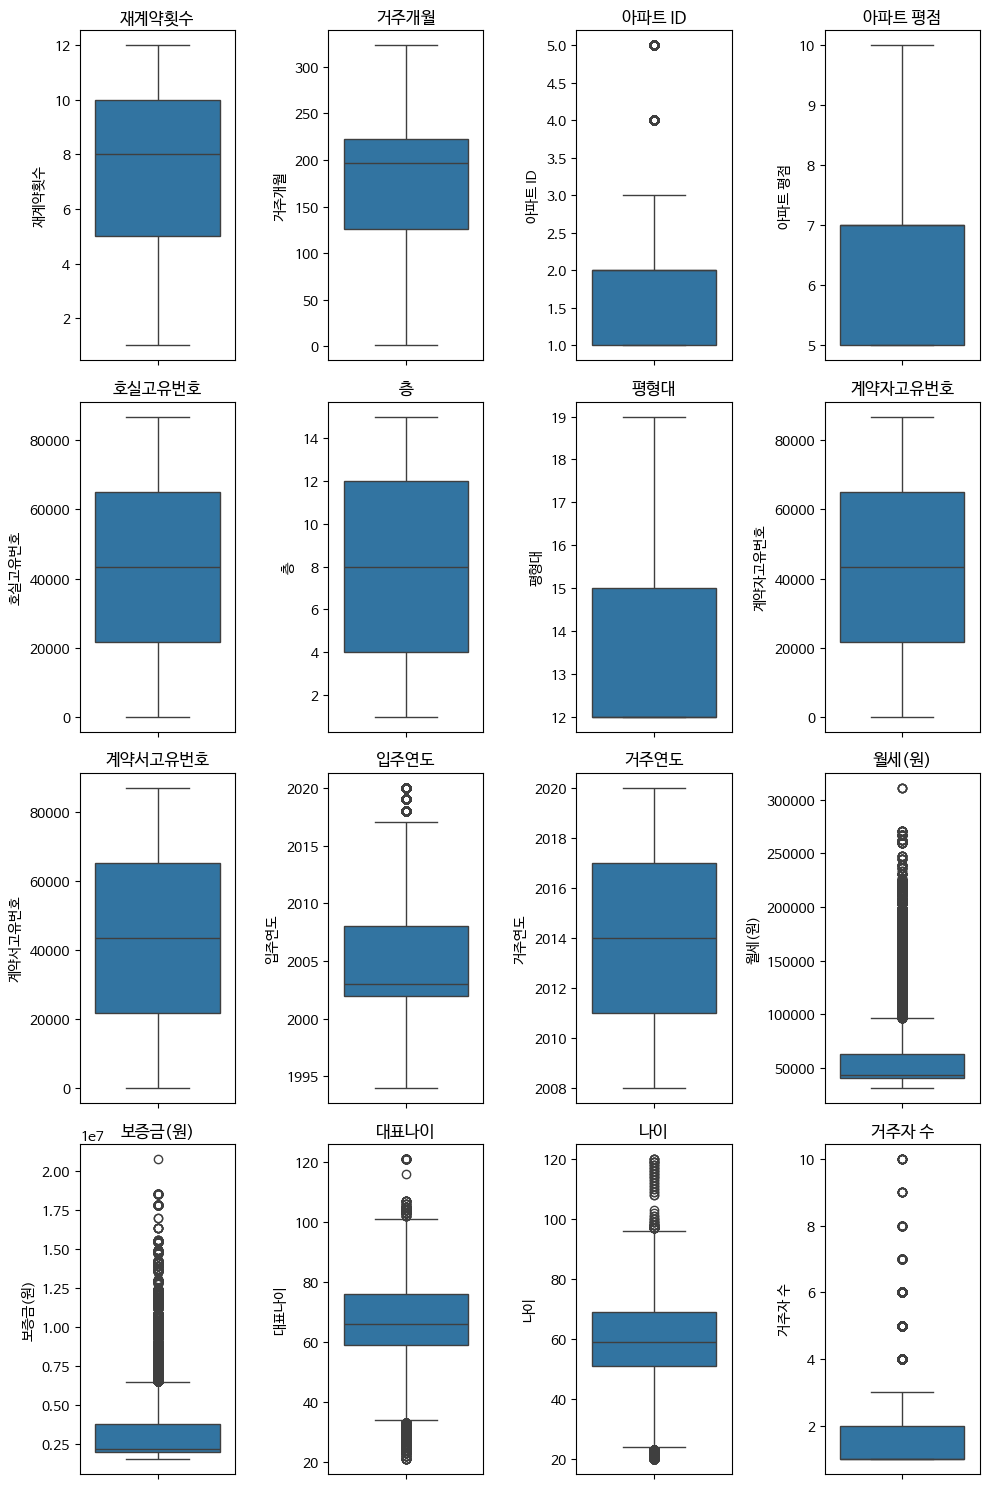

In [13]:
int_col = c_df.select_dtypes(exclude = 'object').columns

# Box Plot으로 이상치 확인
fig, axes = plt.subplots(4,4, figsize = (10, 15))

for axes, col in zip(axes.flatten() , int_col) :
  sns.boxplot(c_df[col] , ax = axes)
  axes.set_title(col)

plt.tight_layout()
plt.show()

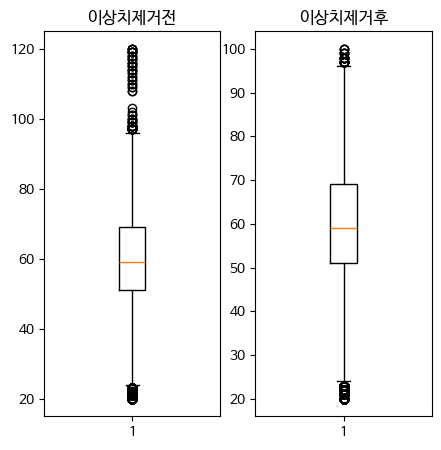

In [14]:
remove_outlier = c_df[c_df['나이'] <= 100]

fig, axes = plt.subplots(1,2, figsize = (5, 5))
axes[0].boxplot(c_df['나이'])
axes[0].set_title('이상치제거전')

axes[1].boxplot(remove_outlier['나이'])
axes[1].set_title('이상치제거후')

# remove_outlier 이상치 제거 데이터 > df3
df3 = remove_outlier.copy()

#### 2-1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.

In [15]:
medi = df3['재계약횟수'].median()
df3['이분변수'] = df3['재계약횟수'].apply(lambda x : '높음' if x >= medi else '낮음')

#### 2-2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.

In [16]:
## 차원 축소 - 항상 종속변수를 제외하고, 독립변수만 적용
## 단
# 전처리
p_df = df3.copy()
pca_df = p_df.drop(columns = ['아파트 ID','호실고유번호','계약서고유번호' ,'계약자고유번호' ,'아파트 이름' ], axis = 1)

df4  = pd.DataFrame()

for col in pca_df.columns :
  if pca_df[col].dtypes == 'object' :
    dummies = pd.get_dummies(pca_df[col] , prefix = col, dtype = int)
    for d_col in dummies.columns :
      df4[d_col] = dummies[d_col]

  else :
    mm = MinMaxScaler()
    df4[col] = mm.fit_transform(pca_df[[col]]).flatten()


display(df4.head() )
print('''
통계적 의미가 있지 않은 고유, 식별 번호의 컬럼들을 제거하며, PCA에서 독립변수들만 가지고 분석하기 떄문에
이분 변수를 분석에서 제외한다.

Label인코딩의 경우, 인위적으로 순서가 부여될 수 있어 해석 단계에서의 한계가 있기 때문에, get_dummies을
이용한 One-Hot encoding 전처리를 범주형 데이터에 적용하고,


수치형은 minmaxscaler로 0~1로 정규화하였는데
이는 단위의 크기가 차이가 있어 0과 1사이에 정규함으로써 변수 간 단위 차이로 인한 분산 편향을 최소화하였다
''')

,계약구분_유효,계약구분_해지,재계약횟수,거주개월,아파트 평점,층,평형대,입주연도,거주연도,월세(원),...,나이,성별_남,성별_여,결혼여부_기혼,결혼여부_미혼,거주자 수,퇴거여부_미퇴거,퇴거여부_퇴거,이분변수_낮음,이분변수_높음
85372,0,1,0.272727,0.270186,0.6,0.357143,0.0,0.423077,0.333333,0.164415,...,0.1875,1,0,1,0,0.111111,0,1,1,0
85371,1,0,0.272727,0.270186,0.6,0.357143,0.0,0.423077,0.250000,0.164415,...,0.1750,1,0,1,0,0.111111,1,0,1,0
85370,1,0,0.272727,0.270186,0.6,0.357143,0.0,0.423077,0.166667,0.111516,...,0.1625,1,0,1,0,0.111111,1,0,1,0
85369,1,0,0.272727,0.270186,0.6,0.357143,0.0,0.423077,0.083333,0.111516,...,0.1500,1,0,1,0,0.111111,1,0,1,0
85368,1,0,0.272727,0.270186,0.6,0.357143,0.0,0.423077,0.000000,0.074344,...,0.1375,1,0,1,0,0.111111,1,0,1,0



통계적 의미가 있지 않은 고유, 식별 번호의 컬럼들을 제거하며, PCA에서 독립변수들만 가지고 분석하기 떄문에
이분 변수를 분석에서 제외한다.

Label인코딩의 경우, 인위적으로 순서가 부여될 수 있어 해석 단계에서의 한계가 있기 때문에, get_dummies을
이용한 One-Hot encoding 전처리를 범주형 데이터에 적용하고,


수치형은 minmaxscaler로 0~1로 정규화하였는데
이는 단위의 크기가 차이가 있어 0과 1사이에 정규함으로써 변수 간 단위 차이로 인한 분산 편향을 최소화하였다



,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22
Ratio,0.310006,0.268151,0.096021,0.086907,0.055822,0.050834,0.046575,0.031441,0.022407,0.015147,...,0.002769,0.00088,0.00013,1.151626e-16,3.259770e-17,2.749499e-17,1.059961e-17,0.0,0.0,0.0
Cumultative,0.310006,0.578157,0.674177,0.761084,0.816907,0.867741,0.914316,0.945757,0.968164,0.983311,...,0.998990,0.99987,1.00000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,1.0



누적 설명 분산 비율이 70%-80%이상이면 주요 정보의 손실이 없이 차원의 축소가 가능하다고 평가한다.
분산 설명력의 경우 5개의 성분을 선택할 경우 데이터의 88% 데이터 설명이 가능하다.
상위 몇 개의 주성분이 전체 분산의 다수를 설명하기 때문에, 정보 손실없이 데이터 구조를 단순화 한다는데
효과적임으로 본 데이터에서의 PCA 차원 축소를 적용하는 것이 타당해 보인다.



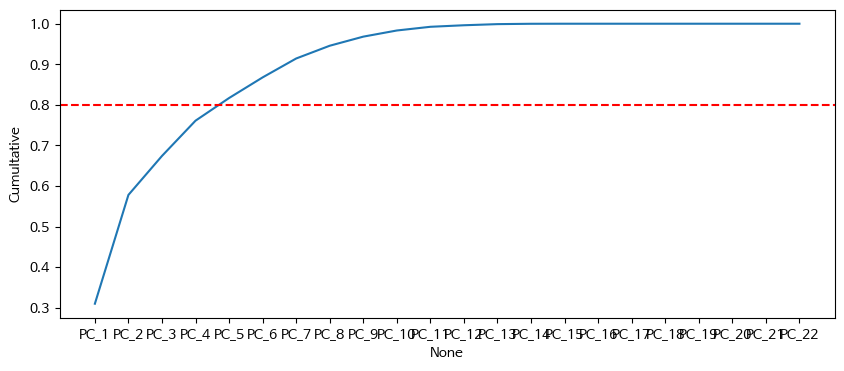

In [17]:
pca = PCA()
pca.fit(df4)

pca_result = pd.DataFrame({
    'Ratio' : pca.explained_variance_ratio_ ,
    'Cumultative' : pca.explained_variance_ratio_.cumsum()
})

pca_result.index = ['PC_'+ str(x + 1) for x in pca_result.index]

display(pca_result.T)

plt.figure(figsize = (10, 4))
sns.lineplot(x= pca_result.index, y = pca_result['Cumultative'])
plt.axhline(0.8, color = 'red' , linestyle = '--')

print('''
누적 설명 분산 비율이 70%-80%이상이면 주요 정보의 손실이 없이 차원의 축소가 가능하다고 평가한다.
분산 설명력의 경우 5개의 성분을 선택할 경우 데이터의 88% 데이터 설명이 가능하다.
상위 몇 개의 주성분이 전체 분산의 다수를 설명하기 때문에, 정보 손실없이 데이터 구조를 단순화 한다는데
효과적임으로 본 데이터에서의 PCA 차원 축소를 적용하는 것이 타당해 보인다.
''')

In [18]:
pca = PCA(n_components= 5)
pca_x = pd.DataFrame(pca.fit_transform(df4), columns = ['PC_' + str(x) for x in range(1,6) ] )

#### 3-1 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.

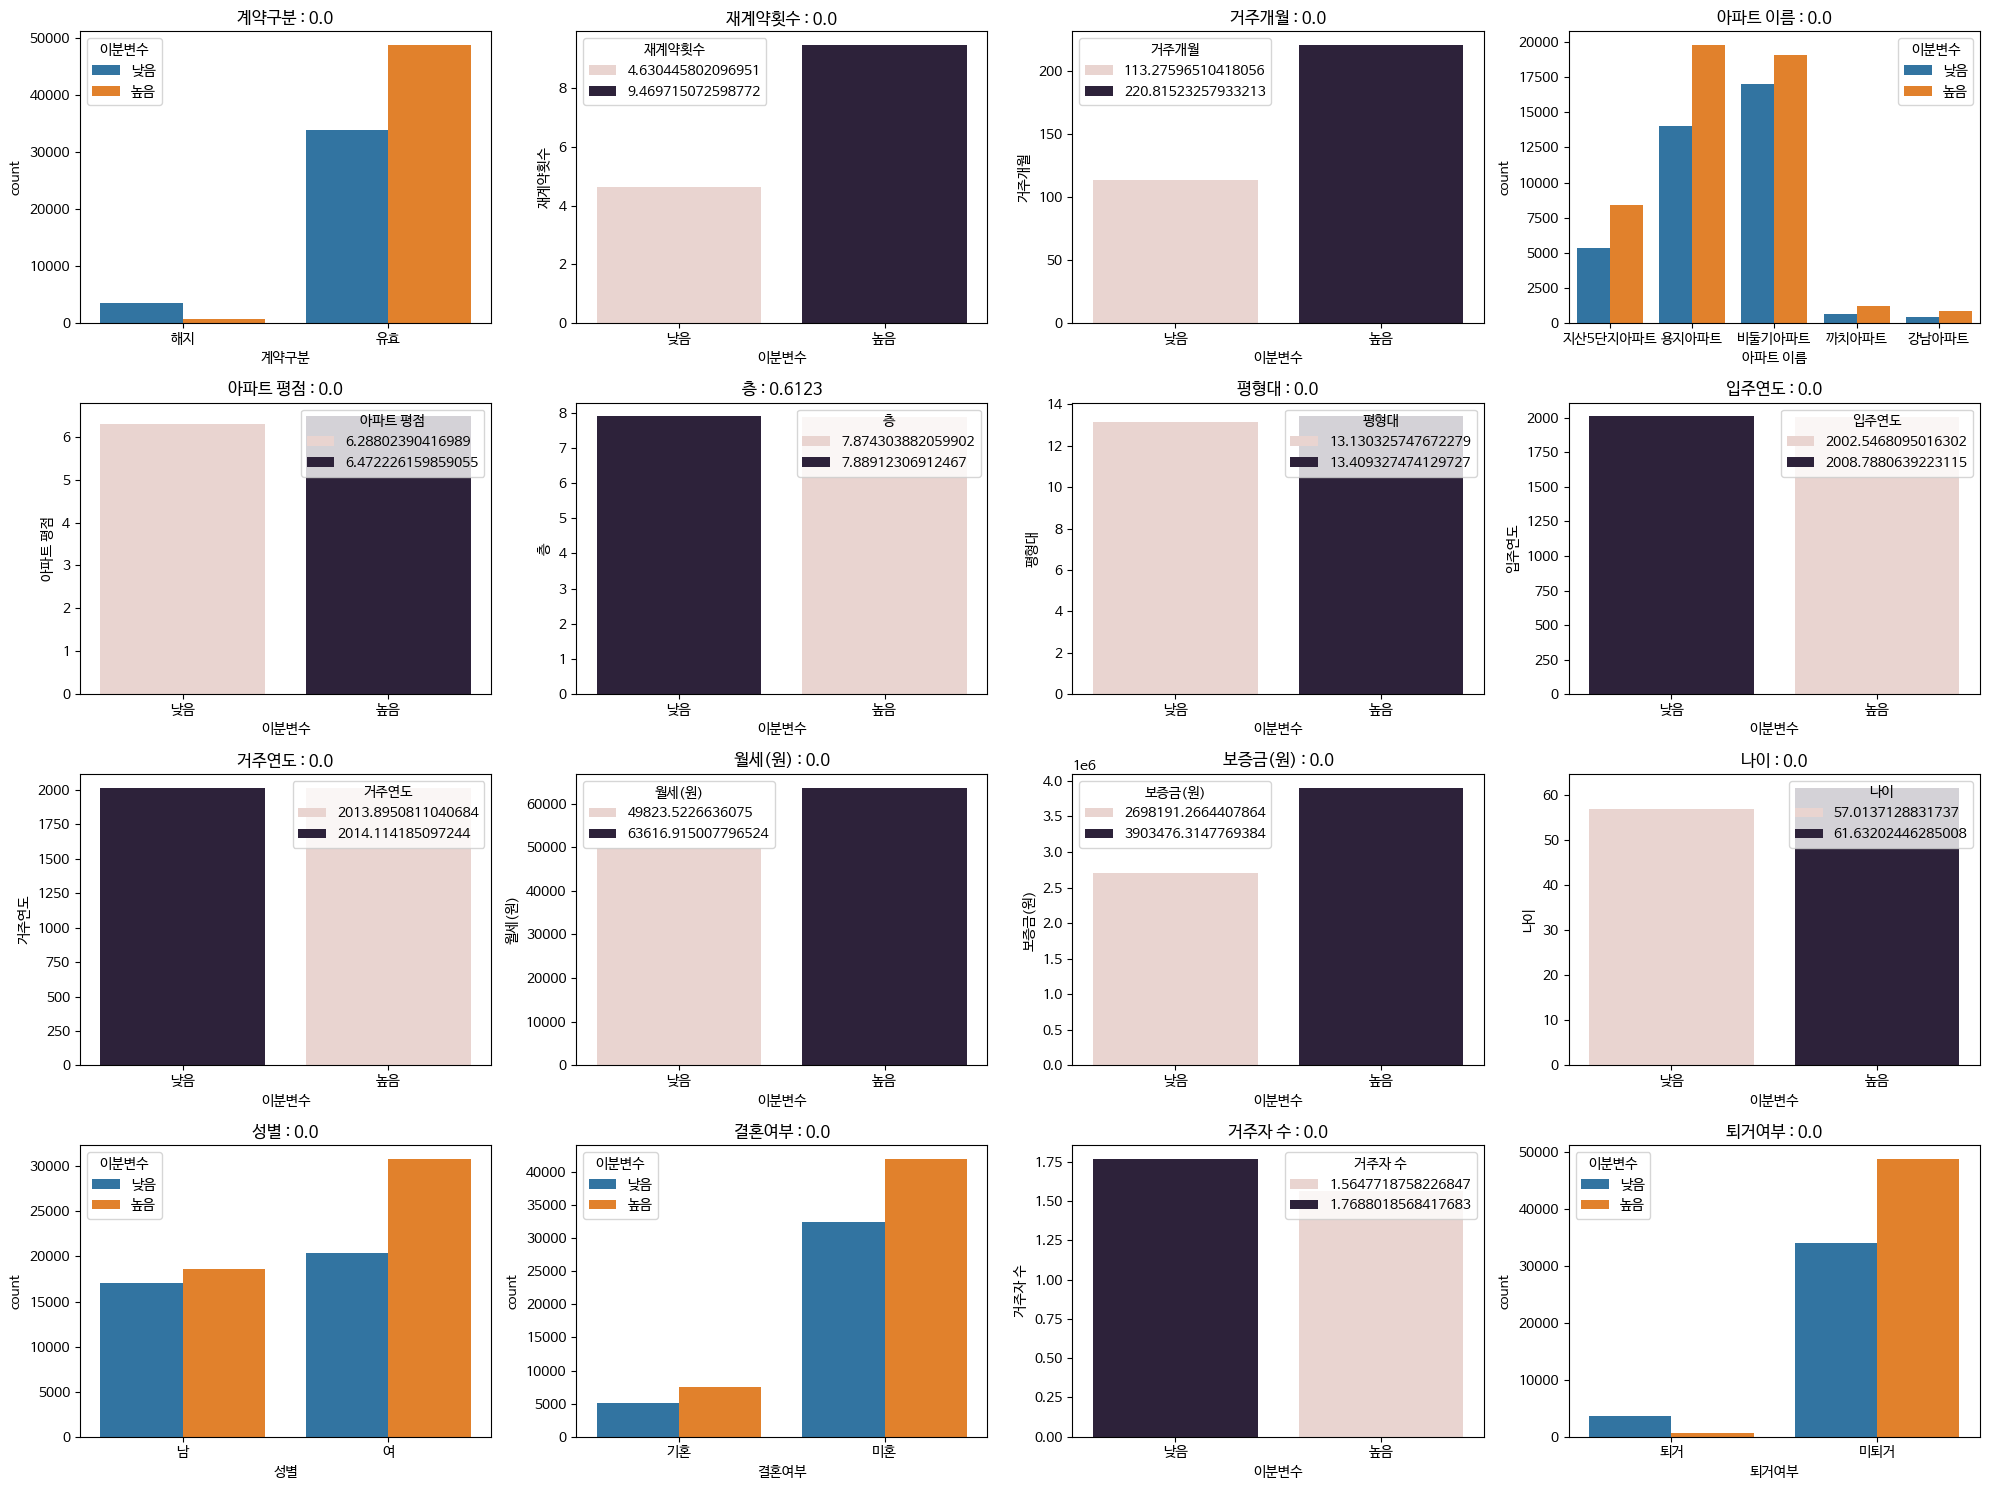

,Col,P_value,Decision
0,재계약횟수,0.000000e+00,유의하다
1,거주개월,0.000000e+00,유의하다
2,아파트 평점,1.734092e-97,유의하다
3,층,6.122735e-01,유의하지않다
4,평형대,1.668102e-65,유의하다
5,입주연도,0.000000e+00,유의하다
6,거주연도,9.703860e-18,유의하다
7,월세(원),0.000000e+00,유의하다
8,보증금(원),0.000000e+00,유의하다
9,나이,0.000000e+00,유의하다


In [19]:
from scipy.stats import chi2_contingency, ttest_ind

cols = ['계약구분', '재계약횟수', '거주개월', '아파트 이름', '아파트 평점', '층',
       '평형대','입주연도', '거주연도', '월세(원)', '보증금(원)',  '나이', '성별', '결혼여부', '거주자 수', '퇴거여부']

res = []

fig, axes = plt.subplots(4,4, figsize = (20, 15))

for axes, col in zip(axes.flatten() , cols):
  if df3[col].dtypes == 'object' :
    cross = pd.crosstab(df3[col] , df3['이분변수'])
    stat, p_val, _, _ = chi2_contingency(cross)

    decision = '유의하다' if p_val < 0.05 else  '유의하지않다'

    sns.countplot(data = df3, x = col, hue = '이분변수' , ax = axes)
    axes.set_title(f'{col} : {round(p_val,4)}')

  else :
    g1 = df3[df3['이분변수'] == '높음'][col]
    g2 = df3[df3['이분변수'] == '낮음'][col]

    stat, p_val = ttest_ind(g1, g2, equal_var = True)

    decision = '유의하다' if p_val < 0.05 else  '유의하지않다'

    target = df3.groupby('이분변수')[col].mean().reset_index()
    sns.barplot(data = target, x = '이분변수' , y = col, hue = col , ax = axes)
    axes.set_title(f'{col} : {round(p_val,4)}')

    res.append([col , p_val , decision])
plt.tight_layout()
plt.show()

display(pd.DataFrame(res, columns = ['Col','P_value','Decision']))

#### 3-2. 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오.

In [20]:
## 재계약횟수 - 회귀분석

# 1. 데이터 전처리
x_cols = ['계약구분', '거주개월', '아파트 이름', '아파트 평점', '층', '이분변수' ,
       '평형대','입주연도', '거주연도', '월세(원)', '보증금(원)',  '나이', '성별', '결혼여부', '거주자 수', '퇴거여부']

model_df = pd.DataFrame()
for col in df3[x_cols].columns :
  if df3[col].dtypes == 'object' :
    dummies = pd.get_dummies(df3[col] , prefix = col, dtype = int)
    for d_col in dummies.columns :
      model_df[d_col] = dummies[d_col]

  else :
    mm = MinMaxScaler()
    model_df[col] = mm.fit_transform(df3[[col]]).flatten()


X = model_df.copy()
y = df3['재계약횟수']


# 2. Modeling
def eval_model(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  r2 = r2_score(y_test, pred)
  rmse = np.sqrt(mean_squared_error(y_test, pred))

  return name, r2, rmse

model_lst = []
res = []
for name, model in [['LR' , LinearRegression()] , ['RF', RandomForestRegressor()]] :
  name, r2, rmse = eval_model(name, model)
  model_lst.append([name, model])
  res.append({
      'Model Name' : name,
      'R2_score' : r2,
      'RMSE' : rmse
  })

print(pd.DataFrame(res))
# RandomForest가 좋은 성능


  Model Name  R2_score      RMSE
0         LR  0.926012  0.755812
1         RF  0.995400  0.188448


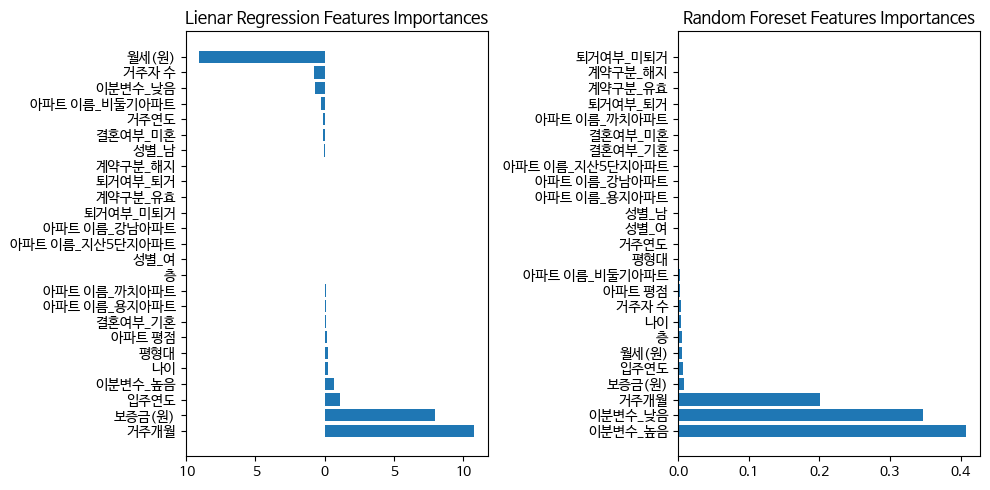

In [21]:
## 재계약 횟수 변수 중요도

fig, axes = plt.subplots(1,2, figsize = (10, 5))
for name, model in model_lst:
  if name == 'LR' :
    features = model.feature_names_in_
    imp = model.coef_
    imp_df= pd.Series(imp , index = features).sort_values(ascending = False)
    title = 'Lienar Regression Features Importances'

    axes[0].barh(imp_df.index, imp_df.values)
    axes[0].set_title(f'{title}')

  elif name == 'RF' :
    features = model.feature_names_in_
    imp = model.feature_importances_
    imp_df = pd.Series(imp, index = features).sort_values(ascending = False)
    title = 'Random Foreset Features Importances'

    axes[1].barh(imp_df.index, imp_df.values)
    axes[1].set_title(f'{title}')

plt.tight_layout()
plt.show()

In [22]:
## 이분변수 - 분류분석

# 1. 데이터 전처리
x_cols = ['계약구분', '거주개월', '아파트 이름', '아파트 평점', '층', '재계약횟수' ,
       '평형대','입주연도', '거주연도', '월세(원)', '보증금(원)',  '나이', '성별', '결혼여부', '거주자 수', '퇴거여부']

clas_df = pd.DataFrame()
for col in df3[x_cols].columns :
  if df3[col].dtypes == 'object' :
    dummies = pd.get_dummies(df3[col] , prefix = col, dtype = int)
    for d_col in dummies.columns :
      clas_df[d_col] = dummies[d_col]

  else :
    mm = MinMaxScaler()
    clas_df[col] = mm.fit_transform(df3[[col]]).flatten()


X = clas_df.copy()
y = df3['이분변수'].map({'높음':1, '낮음':0})


# 2. Modeling
def eval_model(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  f1 = f1_score(y_test, pred)
  acc = accuracy_score(y_test, pred)

  return name, f1, acc

clas_model_lst = []
res = []
for name, model in [['LR' , LogisticRegression()] , ['RF', RandomForestClassifier()]] :
  name, f1, acc  = eval_model(name, model)
  clas_model_lst.append([name, model])
  res.append({
      'Model Name' : name,
      'F1_score' : f1,
      'Accuracy_Score' : acc
  })

print(pd.DataFrame(res))
# RandomForest가 좋은 성능

  Model Name  F1_score  Accuracy_Score
0         LR  0.999762        0.999731
1         RF  1.000000        1.000000


## 3-3 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명하시오

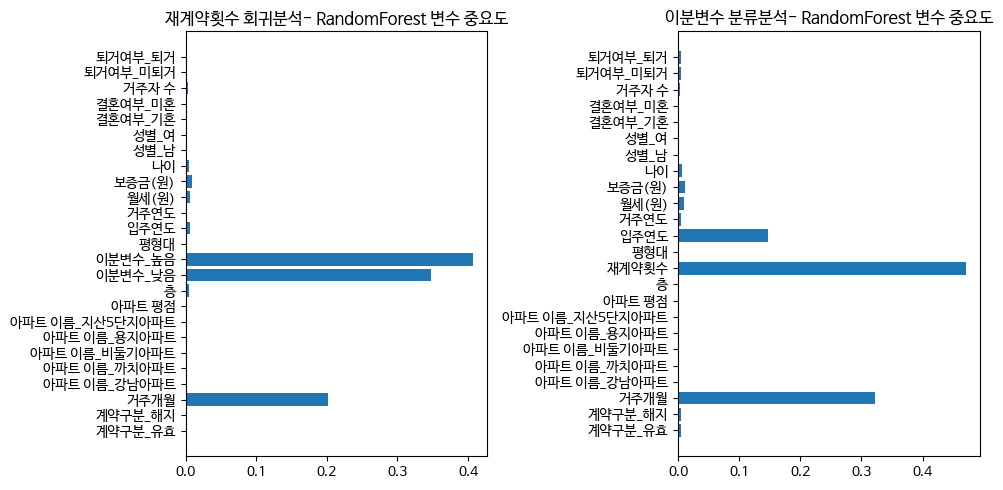

In [23]:
fig, axes = plt.subplots(1,2, figsize = (10, 5))

axes[0].barh(model_lst[1][1].feature_names_in_ , model_lst[1][1].feature_importances_)
axes[0].set_title('재계약횟수 회귀분석- RandomForest 변수 중요도')
axes[1].barh(clas_model_lst[1][1].feature_names_in_ , clas_model_lst[1][1].feature_importances_)
axes[1].set_title('이분변수 분류분석- RandomForest 변수 중요도')


plt.tight_layout()
plt.show()

## 3-4 해당 데이터 분석결과로 얻을 수 있는 점 제시

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018 데이터를 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv
- 데이터 설명 :

A 야구구단의 시합 결과중 일부를 나타낸다.    
각 행은 하나의 경기를 의미(game_id)하며 9회차(= 9이닝) 동안 1번타자, 2번타자의 출루 정보를 의미한다.     
각 컬럼에 대한 설명은 아래 이미지와 같으며, value값의 index는 이미지의 '수치 의미' 열을 통해 확인 할 수 있다.


<img src="https://github.com/Datamanim/datarepo/blob/main/adp/29/p1_img.png?raw=true" width="500" height="600">

#### 4-1 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)     

##### 조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)     
##### 조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.    
##### 조건3 : 학습에 적절하지 않은 데이터는 제외한다.    

제가 이해하고 의도한 29회 4-1번 문제에 대한 가이드 입니다.
(4-1) 전처리 가이드
1. 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
2. 정수형 값이 아닌 데이터 행를 제거
3. 홈런 (4)값을 가지는 행을 제거
4. 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
5. 둘째 타자 출루 결과를 one-hot encoding

In [126]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')
df

cols = df.columns.difference(['game_id'])
cols

Index(['a1_1', 'a1_2', 'a2_1', 'a2_2', 'a3_1', 'a3_2', 'a4_1', 'a4_2', 'a5_1',
       'a5_2', 'a6_1', 'a6_2', 'a7_1', 'a7_2', 'a8_1', 'a8_2', 'a9_1', 'a9_2',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9'],
      dtype='object')

In [127]:
lst = []
for i in range(1,10) :
  x = df[['game_id', f'a{i}_1' , f'a{i}_2' , f'b{i}']]
  x['inning'] = i
  x.columns = ['game_id' ,'a_1', 'a_2', 'score', 'inning']
  lst.append(x)
  p_df = pd.concat(lst, axis = 0).reset_index(drop = True)

# 1) 정수형 값이 아닌 데이터 행을 제거
# - isinstance(x, (int, np.integer)) : x가 int 혹은 np.interger 타입인지 확인한다.
# all(axis = 1) : 모든 행을 봐서 그 위치를 p_df[] True인 곳만 확인
p_df = p_df[p_df.applymap(lambda x : isinstance(x, (int, np.integer))).all(axis = 1)].reset_index(drop = True)

# 방법2) p_df[p_df.map(lambda x : str(x).isdigit)].reset_index()


#### np.where사용시 >> 조건에 맞는 인덱스를 추출

``` python
is_int = p_df.applymap(lambda x :  isinstance(x , (int, np.integer)))
row_idx = np.where(is_int.all(axis = 1))[0]

p_df.iloc[row_idx]
```

In [111]:
# 모든 값이 Floast인 행만 선택

df = pd.DataFrame({
    'a': [1.0, 2.0, 'x', 4.0],
    'b': [3.0, 'y', 5.5, 6.0]
})

is_float = df.map(lambda x : isinstance(x, float))   # True, False로 변환
float_index = np.where(is_float.all(axis = 1))[0]
df.iloc[float_index]

df[df.applymap(lambda x : isinstance(x, float)).all(axis = 1)]

,a,b
0,1.0,3.0
3,4.0,6.0


In [112]:
## 홈런 4값을 가지는 행을 제거
p_df['a_2'] = p_df['a_2'].astype(int)
p_df['a_1'] = p_df['a_1'].astype(int)
four_index = np.where((p_df[['a_1', 'a_2']] == 4).any(axis = 1))[0]

p_df_4 = p_df.drop(index = four_index).reset_index(drop = True)

In [113]:
# 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
p_df_4['binary'] = p_df_4['score'].apply(lambda x : 1 if x >= 1 else 0)

In [114]:
# 둘째 타자 출루 결과를 one-hot encoding

# 1. join 방식
p_df5 = p_df_4.drop(columns = 'a_2', axis = 1).join(pd.get_dummies(p_df_4['a_2'], prefix = 'a_2',dtype= int))

# 2. Assign 방식
#p_df_4.assign(**pd.get_dummies(p_df_4['a_2'] , prefix = 'a_2', dtype = int))

In [115]:
# Assign 용법
df = pd.DataFrame({
    'name': ['Tom', 'Jane', 'Alice'],
    'math': [55, 70, 85],
    'eng': [80, 45, 65]
})

print(df)

# 문제) , 각각 60 이상이면 'pass_math', 'pass_eng' 컬럼을 만들되, assign()을 사용해서 한 줄로 작성

df.assign(
    pass_math = (df['math'] >= 60).astype(int) ,
    pass_eng = (df['eng'] >= 60).astype(int)
)

# np.where로 풀기
#np.where(df['math'] >= 60 , 1, 0)
#np.where(df['eng'] >= 60, 1, 0)

    name  math  eng
0    Tom    55   80
1   Jane    70   45
2  Alice    85   65


,name,math,eng,pass_math,pass_eng
0,Tom,55,80,0,1
1,Jane,70,45,1,0
2,Alice,85,65,1,1


#### 4-2 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 하라

In [123]:
m_df = p_df5.copy()

X = m_df.drop(columns = ['game_id' , 'binary','inning']).astype(int)
y = m_df['binary']

import statsmodels.api as sm_api

add_x = sm_api.add_constant(X)
model = sm_api.Logit(y, add_x).fit()
print(model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 binary   No. Observations:                  905
Model:                          Logit   Df Residuals:                      895
Method:                           MLE   Df Model:                            9
Date:                Thu, 24 Jul 2025   Pseudo R-squ.:                   1.000
Time:                        06:08:46   Log-Likelihood:            -6.6322e-06
converged:                      False   LL-Null:                       -565.34
Covariance Type:            nonrobust   LLR p-value:                1.112e-237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.3902    1.9e+10  -1.23e-09      1.000   -3.72e+10    3.72e+10
a_1            0.4319    239.206      0.002      0.999    -468.40

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 4-3 SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라

In [121]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 0)

sm_x, sm_y = sm.fit_resample(X, y)

print(y.value_counts())
print(sm_y.value_counts())

binary
0    618
1    287
Name: count, dtype: int64
binary
0    618
1    618
Name: count, dtype: int64


#### 4-4 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라

In [125]:

x_train, x_test, y_train, y_test = train_test_split(sm_x, sm_y, test_size= 0.3, random_state  = 1234)
model = sm_api.Logit(y_train.reset_index(drop = True) , x_train.reset_index(drop = True)).fit()
print(model.summary().tables[1])


         Current function value: 0.000003
         Iterations: 35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_1           -0.7052     31.519     -0.022      0.982     -62.481      61.071
score         48.8699   6.22e+04      0.001      0.999   -1.22e+05    1.22e+05
a_2_1        -14.2293    635.338     -0.022      0.982   -1259.468    1231.009
a_2_2         -4.3218    166.994     -0.026      0.979    -331.624     322.980
a_2_3        -18.2804   5.33e+04     -0.000      1.000   -1.04e+05    1.04e+05
a_2_5        -25.6294   6.22e+04     -0.000      1.000   -1.22e+05    1.22e+05
a_2_6        -18.1155   1.15e+04     -0.002      0.999   -2.25e+04    2.25e+04
a_2_7        -27.9114   6.22e+04     -0.000      1.000   -1.22e+05    1.22e+05
a_2_8        -27.3380   1.55e+06  -1.76e-05      1.000   -3.04e+06    3.04e+06
a_2_9        -21.1875   1.81e+04     -0.001      0.999   -3.54e+0

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 4-5 4-3 구성 데이터에 XGB 적용하고 결과를 분석하라

# 통계 (40점)

#### 5. 제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을 구하시오. (소수점 다섯 째 자리에서 반올림)

In [129]:
from scipy.stats import binom
p = 0.03
n = 25

rv = binom(n,p)
res = rv.pmf(3)
print(round(res, 5))

0.03177


#### 6. C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정하여라.

In [134]:
from scipy.stats import norm
n1 = 1000
p1 = 600 / 1000

n2 = 500
p2 = 200 / 500

# 두 비율 차이 검정
# 1) 공통비율구하기
pool = (n1*p1 + n2*p2) / (n1 + n2)

# 2) SE
se = np.sqrt(pool * (1- pool)/n1 + pool * (1- pool)/n2)

# 3) Z검정
d = p1 - p2
z = d / se

# 4) p-value : 차이의 유무만 판별 - 양측 검정
p_val = 2 * (1 - norm.cdf(abs(z)))
print(p_val)


2.4935609133081016e-13


In [136]:
# 풀이 2) 2-Proportion z-test
from statsmodels.stats.proportion import proportions_ztest

sucess = [600, 200]
nobs = [1000, 500]

stat, p_val = proportions_ztest(sucess, nobs)
print(p_val)

2.493596474326038e-13


#### 7. 아래 데이터는 a,b,c,d 네 차종 각각 5회 실험 시 범퍼 파손 정도 이다. (단, 각 모집단은 정규분포를 따르며 모집단 간 등분산성을 가정한다.)

dataurl : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv

#### 7-1. 각 차종 별 범퍼 파손의 정도에 차이가 유의한지 검정하라.

In [148]:
from scipy.stats import shapiro, levene, bartlett, stats
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')
df.head()


,name,ratio
0,A,10.993428
1,A,9.723471
2,A,11.295377
3,A,13.046060
4,A,9.531693


In [143]:
# 정규성 검증
res = []
for group in g.index :
  data = g[group]
  stat, p_val = shapiro(data)

  decision  = '정규분포가아니다' if p_val < 0.05 else '정규분포이다'
  res.append([group, p_val, decision])

pd.DataFrame(res, columns = ['Group','Shapiro_pvalue','Decision'])

,Group,Shapiro_pvalue,Decision
0,A,0.520946,정규분포이다
1,B,0.759866,정규분포이다
2,C,0.364322,정규분포이다
3,D,0.604496,정규분포이다


In [147]:
# 등분산성 검증
g = [group['ratio'] for name, group in df.groupby('name') ]

pval = levene(*g).pvalue

if pval < 0.05 :
  print(f'{pval}으로, 등분산이 아니다')
else :
  print('등분산이다')

등분산이다


In [162]:
# OneWay ANOVA

anova = stats.f_oneway( * [ group['ratio'] for name, group in df.groupby('name')] )
print(anova[0])
print(anova[1])

24.97695307518529
2.8174779556216382e-06


#### 7-2 귀무가설을 채택한다면 그 의미를 해석하고, 귀무가설을 기각하였다면 사후분석을 시행하라.

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B      5.4  0.001   2.1885  8.6115   True
     A      C     -4.0 0.0124  -7.2115 -0.7885   True
     A      D     -0.8 0.8906  -4.0115  2.4115  False
     B      C     -9.4    0.0 -12.6115 -6.1885   True
     B      D     -6.2 0.0002  -9.4115 -2.9885   True
     C      D      3.2  0.051  -0.0115  6.4115  False
-----------------------------------------------------


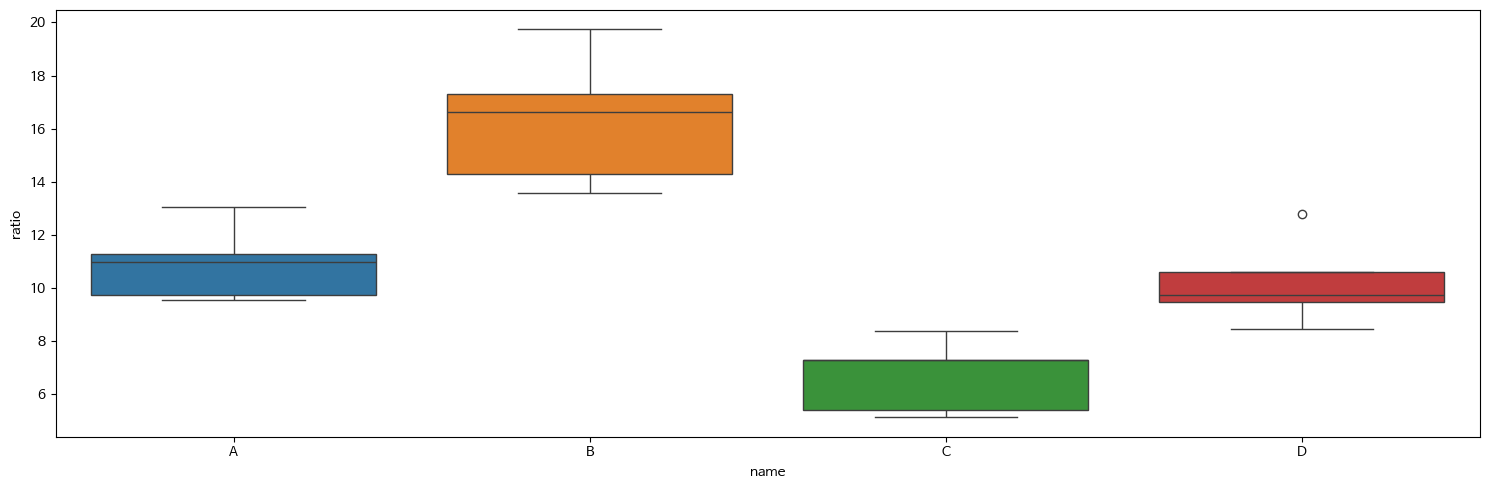

In [163]:
# 그룹 간 차이
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

tukey = pairwise_tukeyhsd(df['ratio'].astype(int), df['name'].astype('category') , alpha = 0.05)
print(tukey)

plt.figure(figsize = (15, 5))
sns.boxplot(x = df['name'], y = df['ratio'], data = df, hue = 'name')
plt.tight_layout()
plt.show()

#### 8. L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률을 구하시오. (소수점 둘째자리에서 반올림)

In [164]:
L1 = 0.13
L2 = 0.37
L3 = 0.50

R1 = 0.011
R2 = 0.021
R3 = 0.033

# 전체 불량율
total = L1 * R1 + L2 * R2 + L3 * R3

# L1일 확률
print(L1*R1 / total)

0.055642023346303505


created by datamanim [web-link](https://www.datamanim.com)

#### 끝. 10페이지